Original by Dirk Roorda [here](https://github.com/ETCBC/bhsa/blob/master/programs/versionPhrases.ipynb). In this version I seek to quantify the changes.

# Phrases in versions of the BHSA

In [versionMappings](versionMappings.ipynb)
we have constructed edge features that map the nodes from one version of the data to the next.
In this notebook we are going to use those edges to study what happened to the feature `function`
of `phrases`.

# Overview

We explore:
* how the values of the `function` feature have changed;
* to what degree phrases have other boundaries.

# Discussion
The feature `function` was called `phrase_function` in version `3`.

## Phrase boundaries
In order to see whether phrase boundaries have changed, we follow the `omap@` edges from 
phrases in one version to their counterparts in the next version.

We make use of the dissimilarity values that are attached to such edges.
If there is no value, or the value is `0`, we have a match without a boundary change.
All other dissimilarities imply that boundaries have changed.

# Results
For the sake of presentation,
we start with the result cells, **they should be run after the other cells**.
The computation starts [here](#Start).

# Changes in `function` values

In [11]:
for (v, w) in reversed(phraseMapping):
    caption(1, 'Phrase function change from version {} to {}'.format(v, w))
    featureDiff(v, w, 'FUNCTION')


##############################################################################################
#                                                                                            #
#      4m 17s Phrase function change from version 3 to 2017                                  #
#                                                                                            #
##############################################################################################



3\2017,Adju,Cmpl,Conj,EPPr,ExsS,Exst,Frnt,IntS,Intj,Loca,ModS,Modi,NCoS,NCop,Nega,Objc,PrAd,PrcS,PreC,PreO,PreS,Pred,PtcO,Ques,Rela,Subj,Supp,Time,Voct
Adju,5438,142,15,,,,18,,,17,,169,,,2,171,84,,111,4,,,,9,2,177,3,20,1
Cmpl,186,22005,9,,,,11,,,25,,11,,,,168,27,,110,,,5,1,3,1,160,3,8,3
Conj,101,51,33064,,,,10,,,17,,151,,,,105,3,,10,2,3,19,,,73,29,,10,1
ExsS,,,,,7,,,,,,,,,,,,,,,,,,,,,,,,
Exst,,,2,,2,90,,,,,1,,3,7,,,,,,,,,,,,,,,
Frnt,8,7,,,,,755,,,,,1,,,,9,,,12,,,,1,,,45,,,5
IntS,,,,,,,,161,,,,,,,,,,,1,,,,,,,,,,
Intj,,1,1,,,,,17,1199,,,6,,,,5,,,9,,,3,,5,,5,,12,1
IrpC,1,18,,,,,,,,,,,,,,,,,3,,,,,,,,,,
IrpO,1,3,,,,,,,,,,,,,,120,,,5,,,,,4,,2,,,



##############################################################################################
#                                                                                            #
#      4m 18s Phrase function change from version 2016 to 2017                               #
#                                                                                            #
##############################################################################################



2016\2017,Adju,Cmpl,Conj,EPPr,ExsS,Exst,Frnt,IntS,Intj,Loca,ModS,Modi,NCoS,NCop,Nega,Objc,PrAd,PrcS,PreC,PreO,PreS,Pred,PtcO,Ques,Rela,Subj,Supp,Time,Voct
Adju,9508,12,2,,,,5,,,2,,,,,,5,,,4,,,,,,,2,,6,
Cmpl,16,30002,4,,,,,,,,,,,,,13,,,1,,,,,,,1,,,
Conj,1,,46135,,,,,,,,,,,,,3,,,,,,,,,3,1,,,
EPPr,,,,21,,,,,,,,,,,,,,,,,,,,,,,,,
ExsS,,,,,14,,,,,,,,,,,,,,,,,,,,,,,,
Exst,,,,,,143,,,,,,,,,,,,,,,,,,,,,,,
Frnt,,1,,,,,1119,,,,,,,,,,,,1,,,,1,,,9,,,
IntS,,,,,,,,251,,,,,,,,,,,,,,,,,,,,,
Intj,,,,,,,,,1621,,,,,,,,,,,,,,,,,,,,
Loca,2,,,,,,,,,2621,,,,,,,,,,,,,,,,,,,



##############################################################################################
#                                                                                            #
#      4m 19s Phrase function change from version 4b to 2016                                 #
#                                                                                            #
##############################################################################################



4b\2016,Adju,Cmpl,Conj,EPPr,ExsS,Exst,Frnt,IntS,Intj,Loca,ModS,Modi,NCoS,NCop,Nega,Objc,PrAd,PrcS,PreC,PreO,PreS,Pred,PtcO,Ques,Rela,Subj,Supp,Time,Voct
Adju,9477,31,1,,,,5,,,1,,1,,,1,11,1,,6,,,,,,1,8,2,1,
Cmpl,39,29921,1,,,,6,,,8,,1,,,2,41,,,24,,,,,,,11,,7,
Conj,1,,46124,,,,,,,,,,,,,,,,1,,,,,,2,1,,,
EPPr,,,,9,,,,,,,,,,,,,,,,,,,,,,,,,
ExsS,,,,,14,,,,,,,,,,,,,,,,,,,,,,,,
Exst,,,,,,143,,,,,,,,,,,,,,,,,,,,,,,
Frnt,,,,,,,1087,,,,,,,,,,,,,,,,,,,25,,,
IntS,,,,,,,,251,,,,,,,,,,,,,,,,,,,,,
Intj,,,,,,,,,1621,,,,,,,,,,,,,,,,,,,,
Loca,3,53,,,,,,,,2613,,,,,1,4,,,2,,,,,,,4,,,



##############################################################################################
#                                                                                            #
#      4m 20s Phrase function change from version 4 to 4b                                    #
#                                                                                            #
##############################################################################################



4\4b,Adju,Cmpl,Conj,EPPr,ExsS,Exst,Frnt,IntS,Intj,Loca,ModS,Modi,NCoS,NCop,Nega,Objc,PrAd,PrcS,PreC,PreO,PreS,Pred,PtcO,Ques,Rela,Subj,Supp,Time,Voct
Adju,8061,94,13,,,,7,,,10,,206,,,1,155,82,,65,5,1,,,8,1,186,3,17,
Cmpl,77,27606,9,,,,2,,,10,,8,,,,65,7,,105,,,3,1,1,5,86,,2,3
Conj,44,39,45936,,,,17,,,10,,6,,,,110,1,,19,1,,3,,,74,42,,7,1
EPPr,,,,4,,,,,,,,,,,,,,,,,,,,,,,,,
ExsS,,,,,14,,,,,,,,,,,,,,,,,,,,,,,,
Exst,,,,,,143,,,,,,,,1,,,,,,,,,,,,,,,
Frnt,1,5,,,,,1007,1,,,,,,,,2,,,5,,,,,,,5,,,3
IntS,,,,,,,,250,,,,,,,,,,,,,,,,,,,,,
Intj,,,,,,,,,1624,,,,,,,,,,,,,,,,,1,,,3
Loca,7,18,,,,,,,,2433,,43,,,,5,,,4,,,,,,,2,,,



##############################################################################################
#                                                                                            #
#      4m 21s Phrase function change from version 3 to 4                                     #
#                                                                                            #
##############################################################################################



3\4,Adju,Cmpl,Conj,EPPr,ExsS,Exst,Frnt,IntS,Intj,Loca,ModS,Modi,NCoS,NCop,Nega,Objc,PrAd,PrcS,PreC,PreO,PreS,Pred,PtcO,Ques,Rela,Subj,Supp,Time,Unkn,Voct
Adju,6067,74,15,,,,6,,,10,,31,,,,43,19,,65,,,,,,1,43,,15,,2
Cmpl,90,22418,12,,,,5,,,14,,6,,,1,79,26,,21,,,3,,1,1,71,3,6,,2
Conj,87,27,33540,,,,6,,,8,,154,,,,36,2,,5,2,3,18,,,39,22,,7,,1
ExsS,,,,,7,,,,,,,,,,,,,,,,,,,,,,,,,
Exst,,,,,2,90,,,,,1,,3,9,,,,,,,,,,,,,,,,
Frnt,8,2,1,,,,785,,,,,,,,,8,,,12,,,,,,,22,,,,5
IntS,,,,,,,,161,,,,,,,,,,,1,,,,,,,,,,,
Intj,,1,2,,,,,17,1199,,,16,,,,5,,,9,,,3,,5,,5,,1,,1
IrpC,1,18,,,,,,,,,,,,,,,,,3,,,,,,,,,,,
IrpO,1,1,,,,,,,,,,,,,,130,,,1,,,,,2,,,,,,


# Boundary statistics

In [12]:
for (v, w) in reversed(phraseMapping):
    caption(1, 'Phrase boundary change from version {} to {}'.format(v, w))
    showStats(v, w)


##############################################################################################
#                                                                                            #
#      1m 30s Phrase boundary change from version 3 to 2017                                  #
#                                                                                            #
##############################################################################################



dissimilarity,number of phrases
0,251551
1,29
2,26
3,22
4,13
5,10
6,5
7,6
8,1
9,13



##############################################################################################
#                                                                                            #
#      1m 30s Phrase boundary change from version 2016 to 2017                               #
#                                                                                            #
##############################################################################################



dissimilarity,number of phrases
0,253073
1,29
2,26
3,22
4,13
5,10
6,5
7,6
8,1
9,13



##############################################################################################
#                                                                                            #
#      1m 30s Phrase boundary change from version 4b to 2016                                 #
#                                                                                            #
##############################################################################################



dissimilarity,number of phrases
0,252881
1,128
2,82
3,65
4,26
5,16
6,11
7,14
8,11
9,5



##############################################################################################
#                                                                                            #
#      1m 30s Phrase boundary change from version 4 to 4b                                    #
#                                                                                            #
##############################################################################################



dissimilarity,number of phrases
0,250751
1,750
2,745
3,618
4,372
5,305
6,188
7,141
8,123
9,77



##############################################################################################
#                                                                                            #
#      1m 30s Phrase boundary change from version 3 to 4                                     #
#                                                                                            #
##############################################################################################



dissimilarity,number of phrases
0,250346
1,2837
2,1164
3,788
4,457
5,287
6,166
7,127
8,86
9,61


# Start
Start the program here.

In [1]:
import os, sys, collections
from functools import reduce
from utils import caption
from tf.fabric import Fabric

from IPython.display import HTML, display

We specify our versions and the subtle differences between them as far as they are relevant.

In [2]:
REPO = os.path.expanduser('~/github/etcbc/bhsa')
baseDir = '{}/tf'.format(REPO)
tempDir = '{}/_temp'.format(REPO)

versions = '''
    3 
    4 
    4b 
    2016
    2017
'''.strip().split()

versionInfoSpec = {
    '': dict(
            OCC='g_word',
            LEX='lex',
            FUNCTION='function',
        ),
    '3': dict(
            OCC='text_plain',
            LEX='lexeme',
            FUNCTION='phrase_function',
        ),
}

versionInfo = {}

defaults = versionInfoSpec[''].items()

for (i, v) in enumerate(versions):
    versionInfo.setdefault(v, {})['OMAP'] = '' if i == 0 else 'omap@{}-{}'.format(versions[i-1], v)
    versionInfo[v].update(versionInfoSpec.get('', {}))
    versionInfo[v].update(versionInfoSpec.get(v, {}))

Load all versions in one go, with the version mapping feature if present.

In [3]:
TF = {}
api = {}
for (i, v) in enumerate(versions):
    for (param, value) in versionInfo[v].items():
        globals()[param] = value
    caption(4, 'Version -> {} <- loading ...'.format(v))
    TF[v] = Fabric(locations='{}/{}'.format(baseDir, v), modules=[''])
    api[v] = TF[v].load(' '.join((OCC, LEX, FUNCTION, OMAP)))

..............................................................................................
.       0.00s Version -> 3 <- loading ...                                                    .
..............................................................................................
This is Text-Fabric 5.5.18
Api reference : https://dans-labs.github.io/text-fabric/Api/General/
Tutorial      : https://github.com/Dans-labs/text-fabric/blob/master/docs/tutorial.ipynb
Example data  : https://github.com/Dans-labs/text-fabric-data

118 features found and 0 ignored
  0.00s loading features ...
   |     0.63s T otype                from /Users/cody/github/etcbc/bhsa/tf/3
   |     7.50s T oslots               from /Users/cody/github/etcbc/bhsa/tf/3
   |     0.06s T book                 from /Users/cody/github/etcbc/bhsa/tf/3
   |     0.04s T chapter              from /Users/cody/github/etcbc/bhsa/tf/3
   |     0.03s T verse                from /Users/cody/github/etcbc/bhsa/tf/3
   |     1.04s 

# Utility function: tables in your cells

In [4]:
def tableText(table):
    return display(HTML(
        '<table><tr>{}</tr></table>'.format(
            '</tr><tr>'.join(
                '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in table)
            )
     ))

# Get counterparts

Here is a function that gets the counterparts of phrases between versions, and classifies them according to dissimilarity.

`phraseMapping` is keyed by a (source version, target version) pair,
then by dissimilarity, then by node in source version, and then
the value is a node in the target version.

Source nodes that lack a counterpart, end up in a bucket with dissimilarity -1.

In [5]:
phraseMapping = collections.OrderedDict()

In [6]:
def getPhrases(v, w):
    V = api[v]
    W = api[w]
    mapVW = 'omap@{}-{}'.format(v, w)
    vKey = (v, w)
    
    phraseMapping[vKey] = {}
    phrases = phraseMapping[vKey]
    
    for n in V.F.otype.s('phrase'):
        ms = W.Es(mapVW).f(n)
        if ms != None :
            phrases[n] = ms

We also want to see the evolution in one big leap, so we construct a mapping from the first version to the last,
just by composing the individual `omap@`s into a stride. 

Picking a phrase, and following it through the versions might lead to multiple counterparts.
When that happens, we choose the one with the highest similarity, and ignore the rest.

In [7]:
def composeMap(curMap, newStep):
    resultMap = {}
    for (n, ms) in curMap.items():
        theM = ms[0][0] if len(ms) == 1 else sorted(ms, key=lambda x: (x[1], x[0]))[0][0]
        resultMap[n] = newStep[theM]
    return resultMap
    
def getFirstLastMapping():
    if len(versions) <= 2:
        return {}
    curMap = phraseMapping[(versions[0], versions[1])]
    
    for i in range(2, len(versions)):
        caption(0, 'mapping from {} to {}'.format(versions[0], versions[i]))
        curMap = composeMap(curMap, phraseMapping[(versions[i-1], versions[i])])
    phraseMapping[(versions[0], versions[-1])] = curMap

# Table of boundary changes

In [8]:
def showStats(v, w):
    vKey = (v, w)
    phrases = phraseMapping[vKey]
    dists = {}
    for (n, ms) in phrases.items():
        for (m, dis) in ms:
            dists.setdefault(dis or 0, set()).add(m)
    stats = collections.Counter()
    for (dis, ms) in dists.items():
        stats[dis] = len(ms)
    table = []
    table.append(['dissimilarity', 'number of phrases'])
    for dis in range(0, max(stats) + 1):
        table.append([dis, stats.get(dis, '')])
    tableText(table)

# Table of old and new values
We visualize the changes in the values of the `function` feature,
by generating a matrix, with old values in the row headers
and new values in the column headers, and the number of times that this old feature has changed into that new
feature in the corresponding matrix cells.

In [9]:
def featureDiff(v, w, feat):
    V = api[v]
    W = api[w]
    vKey = (v, w)
    vFeat = versionInfo[v][feat]
    wFeat = versionInfo[w][feat]
    phrases = phraseMapping[vKey]

    combis = {}
    for (n, ms) in phrases.items():
        vVal = V.Fs(vFeat).v(n)
        for (m, dis) in ms:
            wVal = W.Fs(wFeat).v(m)
            combis.setdefault(vVal, collections.Counter())[wVal] += 1
    vValues = sorted(combis.keys())
    wValues = sorted(reduce(set.union, [set(combis[v]) for v in vValues], set()))
    table = []
    table.append(['{}\\{}'.format(v, w)] + wValues)
    for v in vValues:
        table.append([v] + [str(combis[v].get(w, '')) for w in wValues])
    tableText(table)   

# Collect
We collect all data in a big data structure.

In [10]:
caption(4, 'Collecting data')
for (i, w) in enumerate(versions):
    if i == 0: continue
    v = versions[i-1]
    caption(0, '\t{:<4} => {:<4}'.format(v, w))
    getPhrases(v, w)

caption(0, '\t{:<4} => {:<4}'.format(versions[0], versions[-1]))
getFirstLastMapping()
caption(0, 'Done')

..............................................................................................
.      4m 03s Collecting data                                                                .
..............................................................................................
|      4m 03s 	3    => 4   
|      4m 03s 	4    => 4b  
|      4m 04s 	4b   => 2016
|      4m 05s 	2016 => 2017
|      4m 05s 	3    => 2017
|      4m 05s mapping from 3 to 4b
|      4m 05s mapping from 3 to 2016
|      4m 05s mapping from 3 to 2017
|      4m 05s Done


# Stats

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
def featureDiffDATA(v, w, feat):
    V = api[v]
    W = api[w]
    vKey = (v, w)
    vFeat = versionInfo[v][feat]
    wFeat = versionInfo[w][feat]
    phrases = phraseMapping[vKey]

    combis = {}
    for (n, ms) in phrases.items():
        vVal = V.Fs(vFeat).v(n)
        for (m, dis) in ms:
            wVal = W.Fs(wFeat).v(m)
            combis.setdefault(vVal, collections.Counter())[wVal] += 1
    vValues = sorted(combis.keys())
    wValues = sorted(reduce(set.union, [set(combis[v]) for v in vValues], set()))
    table = []
    table.append(['{}\\{}'.format(v, w)] + wValues)
    for v in vValues:
        table.append([v] + [str(combis[v].get(w, '')) for w in wValues])
    return table


In [18]:
phraseMapping = collections.OrderedDict()

In [19]:
caption(4, 'Collecting data')
for (i, w) in enumerate(versions):
    if i == 0: continue
    v = versions[i-1]
    caption(0, '\t{:<4} => {:<4}'.format(v, w))
    getPhrases(v, w)

caption(0, '\t{:<4} => {:<4}'.format(versions[0], versions[-1]))
getFirstLastMapping()
caption(0, 'Done')

..............................................................................................
.      7m 39s Collecting data                                                                .
..............................................................................................
|      7m 39s 	3    => 4   
|      7m 40s 	4    => 4b  
|      7m 42s 	4b   => 2016
|      7m 43s 	2016 => 2017
|      7m 44s 	3    => 2017
|      7m 44s mapping from 3 to 4b
|      7m 44s mapping from 3 to 2016
|      7m 44s mapping from 3 to 2017
|      7m 44s Done


In [22]:
phraseMapping.keys()

odict_keys([('3', '4'), ('4', '4b'), ('4b', '2016'), ('2016', '2017'), ('3', '2017')])

In [134]:
def make_int(string):
    if string:
        return int(string)
    else:
        return 0

diff_data = featureDiffDATA('3', '2017', 'FUNCTION')
row_data = [[make_int(value) for value in dat[1:]] for dat in diff_data[1:]]
row_names = diff_data[0][1:]
col_names = [dat[0] for dat in diff_data[1:]]

diff_data = pd.DataFrame(row_data, columns=row_names, index=col_names)
diff_data.drop('Unkn', inplace=True)

# zero out identical items
for col in diff_data.columns:
    for row in diff_data.index:
        if col == row:
            diff_data[col][row] = 0

### Total Changes:

In [137]:
diff_data.sum().sum()

8723

### Changes Visualized

Text(0.5,1,'Phrase Function Changes from 2011–2017')

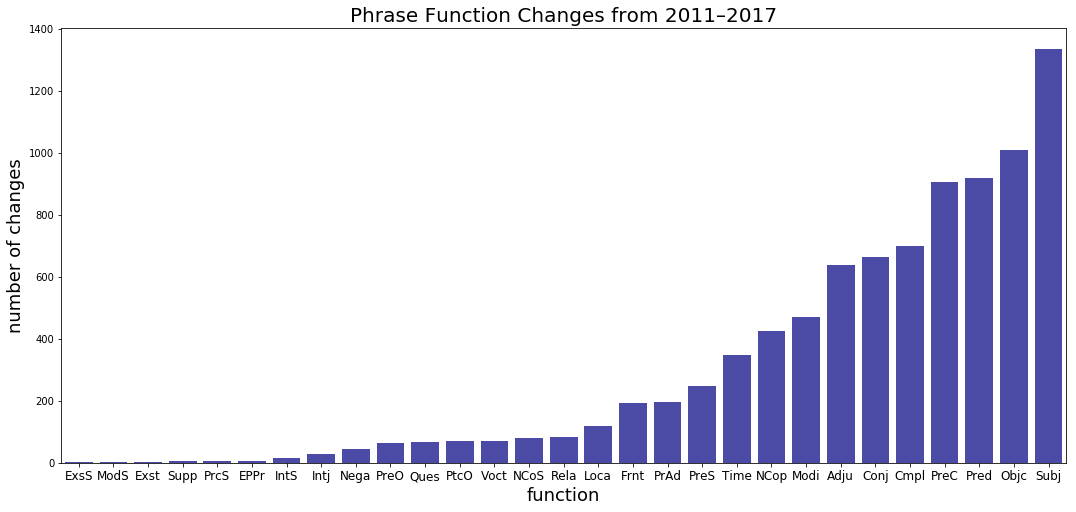

In [162]:
plt.figure(figsize=(18, 8)) 
sns.barplot(diff_data.sum().sort_values().index, diff_data.sum().sort_values(), color='#3C3CB4')
plt.xticks(fontsize=12)
plt.xlabel('function', fontsize=18)
plt.ylabel('number of changes', fontsize=18)
plt.title(f'Phrase Function Changes from 2011–2017', fontsize=20)
        